# 「深層学習」読書会　〜第7章〜

<p style="text-align:center;font-size:150%;line-height:150%">2016/07/02 機械学習 名古屋 第5回勉強会</p>

## 第7章 再帰型ニューラルネット

abstract:

+ RNN（再帰型ニューラルネットワーク）
    + 以下のようなデータの特徴をうまく取り扱うNN：
        + データの長さがサンプルごとにまちまち
        + 系列内の要素の並び（＝コンテキスト）に意味がある
    + 例：音声・言語・動画
+ LSTM（長・短期記憶）
    + より長期のコンテキストをモデル化可能
+ CTC（コネクショニスト時系列分類法）
    + 入力系列とは長さの異なる系列を推定（出力）

### 7.1 系列データの分類

**系列データ**：

+ 個々の要素の順序付き集まりデータ

$$
{\bf x}^1, {\bf x}^2, {\bf x}^3, \dots , {\bf x}^T
$$

+ 音声・動画・テキストなど
+ 系列の長さ $T$ は、一般に可変
+ インデックス $t = 1, 2, 3, \dots$ を **時刻**と呼ぶ（*時間*とは言ってない）。

**RNN（再帰型ニューラルネット）**：
コンテキストを学習し、分類出来る。

**コンテキスト（文脈）**：系列内の要素の並び、依存関係

要素の例：

+ 文章中の「単語」
+ 音声信号中の「音素」

### 7.2 RNNの構造

**RNN（再帰型ニューラルネット）**：

+ 内部に（有向）閉路を持つNNの総称
+ 特徴：
    + 情報を一時的に記憶
    + 振る舞いを動的に変化

In [1]:
from graphviz import Digraph

In [2]:
fig_7_3_a = Digraph("fig_7_3_a", format="svg")
fig_7_3_a.graph_attr.update(compound="true", splines="line")

fig_7_3_a.body.extend(['rankdir=BT'])

fig_7_3_a.node_attr.update(shape='circle', color='black', penwidth='2')
fig_7_3_a.node('na1', '')
fig_7_3_a.node('na2', '')
fig_7_3_a.node('na3', 'i')
fig_7_3_a.node('nc1', '')
fig_7_3_a.node('nc2', '')
fig_7_3_a.node('nc3', 'k')

c0 = Digraph('cluster0')
c0.node('nb1', '')
c0.node('nb2', '')
c0.node('nb3', 'j')
c0.node('nb4', '')

fig_7_3_a.subgraph(c0)

fig_7_3_a.edge('na1', 'nb1')
fig_7_3_a.edge('na1', 'nb2')
fig_7_3_a.edge('na1', 'nb3')
fig_7_3_a.edge('na1', 'nb4')
fig_7_3_a.edge('na2', 'nb1')
fig_7_3_a.edge('na2', 'nb2')
fig_7_3_a.edge('na2', 'nb3')
fig_7_3_a.edge('na2', 'nb4')
fig_7_3_a.edge('na3', 'nb1')
fig_7_3_a.edge('na3', 'nb2')
fig_7_3_a.edge('na3', 'nb3')
fig_7_3_a.edge('na3', 'nb4')
fig_7_3_a.edge('nb1', 'nc1')
fig_7_3_a.edge('nb1', 'nc2')
fig_7_3_a.edge('nb1', 'nc3')
fig_7_3_a.edge('nb2', 'nc1')
fig_7_3_a.edge('nb2', 'nc2')
fig_7_3_a.edge('nb2', 'nc3')
fig_7_3_a.edge('nb3', 'nc1')
fig_7_3_a.edge('nb3', 'nc2')
fig_7_3_a.edge('nb3', 'nc3')
fig_7_3_a.edge('nb4', 'nc1')
fig_7_3_a.edge('nb4', 'nc2')
fig_7_3_a.edge('nb4', 'nc3')


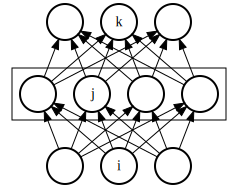

In [3]:
fig_7_3_a

In [4]:
fig_7_3_b = Digraph("fig_7_3_b", format="svg")
fig_7_3_b.graph_attr.update(compound="true", splines="line")

fig_7_3_b.body.extend(['rankdir=BT'])

fig_7_3_b.node_attr.update(shape='circle', color='black', penwidth='2')

c1 = Digraph('cluster_1')
c1.body.append('label="t-1"')
c1.node('nc11', '')
c1.node('nc12', 'j\'')
c1.node('nc13', '')
c1.node('nc14', '')

c2 = Digraph('cluster_2')
c2.body.append('label="t"')
c2.body.append('labelloc="b"')
c2.node('nc21', '')
c2.node('nc22', '')
c2.node('nc23', 'j')
c2.node('nc24', '')

fig_7_3_b.subgraph(c1)
fig_7_3_b.subgraph(c2)

fig_7_3_b.edge('nc11', 'nc21')
fig_7_3_b.edge('nc11', 'nc22')
fig_7_3_b.edge('nc11', 'nc23')
fig_7_3_b.edge('nc11', 'nc24')
fig_7_3_b.edge('nc12', 'nc21')
fig_7_3_b.edge('nc12', 'nc22')
fig_7_3_b.edge('nc12', 'nc23')
fig_7_3_b.edge('nc12', 'nc24')
fig_7_3_b.edge('nc13', 'nc21')
fig_7_3_b.edge('nc13', 'nc22')
fig_7_3_b.edge('nc13', 'nc23')
fig_7_3_b.edge('nc13', 'nc24')
fig_7_3_b.edge('nc14', 'nc21')
fig_7_3_b.edge('nc14', 'nc22')
fig_7_3_b.edge('nc14', 'nc23')
fig_7_3_b.edge('nc14', 'nc24')


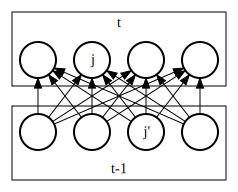

In [5]:
fig_7_3_b

In [6]:
fig_7_4 = Digraph("fig_7_4", format="svg")
fig_7_4.graph_attr.update(compound="true")

fig_7_4.body.extend(['rankdir=BT'])

fig_7_4.node('x', 'x_t', shape='circle', color='black', penwidth='2')
fig_7_4.node('A', 'A', shape='rect', color='black', penwidth='2')
fig_7_4.node('y', 'y_t', shape='circle', color='black', penwidth='2')

fig_7_4.node('x0', 'x_0', shape='circle', color='black', penwidth='2')
fig_7_4.node('A0', 'A', shape='rect', color='black', penwidth='2')
fig_7_4.node('y0', 'y_0', shape='circle', color='black', penwidth='2')
fig_7_4.node('x1', 'x_1', shape='circle', color='black', penwidth='2')
fig_7_4.node('A1', 'A', shape='rect', color='black', penwidth='2')
fig_7_4.node('y1', 'y_1', shape='circle', color='black', penwidth='2')
fig_7_4.node('x2', 'x_2', shape='circle', color='black', penwidth='2')
fig_7_4.node('A2', 'A', shape='rect', color='black', penwidth='2')
fig_7_4.node('y2', 'y_2', shape='circle', color='black', penwidth='2')
fig_7_4.node('xt', 'x_t', shape='circle', color='black', penwidth='2')
fig_7_4.node('At', 'A', shape='rect', color='black', penwidth='2')
fig_7_4.node('yt', 'y_t', shape='circle', color='black', penwidth='2')

fig_7_4.edge('x', 'A')
fig_7_4.edge('A', 'y')

fig_7_4.edge('A', 'A', minlen="2", dir="back")

fig_7_4.edge('x0', 'A0')
fig_7_4.edge('A0', 'y0')
fig_7_4.edge('x1', 'A1')
fig_7_4.edge('A1', 'y1')
fig_7_4.edge('x2', 'A2')
fig_7_4.edge('A2', 'y2')
fig_7_4.edge('xt', 'At')
fig_7_4.edge('At', 'yt')

fig_7_4.edge('x2', 'xt', minlen="2", constraint="false", color="transparent", label="…")

fig_7_4.edge('A', 'A0', minlen="3", constraint="false", color="transparent", label="=", fontsize="28.0")

fig_7_4.edge('A0', 'A1', minlen="1", constraint="false")
fig_7_4.edge('A1', 'A2', minlen="1", constraint="false")
fig_7_4.edge('A2', 'At', minlen="2", constraint="false")


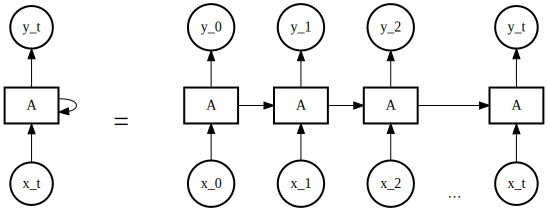

In [7]:
fig_7_4

誤差関数：（順伝播ネットワークと同様）

$$
E({\bf w}) = - \sum_n \sum_t \sum_k d^t_{nk} \log y^t_k({\bf x}_n; {\bf w})
$$

ただし $d^t_n$：$n$ 番目のサンプル ${\bf x}_n$ に対する、時刻 $t$ での目標出力  
（$(d^t_{n1}, d^t_{n2}, \dots , d^t_{nk})$ というベクトル）

**双方向RNN**：  
データを 順方向 逆方向 両方の入力で与えるRNNを統合したもの。

+ データの数が有限ならば有効
+ オンライン学習には不向き

### 7.3 順伝播計算

《略》

### 7.4 逆伝播計算

《略》

### 7.5 長・短期記憶（LSTM）

#### 7.5.1 RNN の勾配消失問題

In [8]:
%matplotlib inline
%config InlineBackend.figure_formats = {'svg',}

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf


In [9]:
def gradient_vanishing_image():
    x_linspace = tf.constant(np.linspace(-5.0, 5.0))
    grad1 = tf.sigmoid(x_linspace)
    grad2 = tf.sigmoid(grad1)
    grad3 = tf.sigmoid(grad2)
    
    with tf.Session() as sess:
        x, y1, y2, y3 = sess.run([x_linspace, grad1, grad2, grad3])
        plt.plot(x, y1, "b")
        plt.plot(x, y2, "g")
        plt.plot(x, y3, "r")

※イメージ

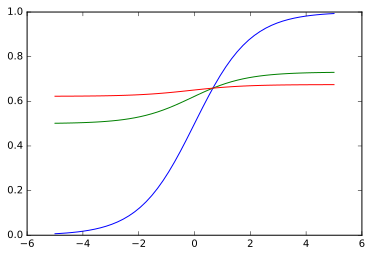

In [10]:
gradient_vanishing_image()

※ RNNの、ではなく一般のDNNの勾配消失イメージです。`sigmoid`関数を重ねて適用するとだんだん平らになっていくという実例。

#### 7.5.2 LSTM の概要

**LSTM（長・短期記憶）**：  
RNNの拡張モデル（の1つ）。  
RNNの中間層の各ユニットをメモリユニットと呼ぶ要素で置き換えた構造を持つ。

In [11]:
fig_7_7 = Digraph("fig_7_7", format="svg")
fig_7_7.graph_attr.update(compound='true', ranksep="0.3 equally")
fig_7_7.body.extend(['rankdir=BT'])

cb = Digraph('clusterB')
cb.graph_attr.update(color='transparent')
cb.node('x00', '', shape='none', pos='0')
cb.node('x0', '', shape='none', pos='0')
cb.node('x01', '', shape='none', pos='0')

fig_7_7.subgraph(cb)

c1 = Digraph('cluster1')
c1.graph_attr.update(color='transparent')
c1.node('xb0', '', shape='none')
c1.node('xc0', '', shape='none')
c1.node('xf', '', shape='none')
c1.node('xd0', '', shape='none')
c1.edge('xb0', 'xc0', color='transparent')
c1.edge('xc0', 'xf', color='transparent')
c1.edge('xf', 'xd0', color='transparent')

fig_7_7.subgraph(c1)
fig_7_7.edge('x00', 'xb0', color='transparent')
fig_7_7.edge('xf', 'FG', constraint='false', minlen="2", ltail='cluster1')

c_main = Digraph('cluster_main')
c_main.node('B', 'B', shape='circle', style='filled', fillcolor='#009999', penwidth='2', pos='0')

s1 = Digraph('subgraph1')
s1.graph_attr.update(rank="same")
s1.node('c_main', '', shape='none')
s1.node('e0', '', shape='circle', width='0.3', style='filled', fillcolor='#0000cc', penwidth='1', pos='0')
s1.node('IG', 'C', shape='circle', style='filled', fillcolor='#00cc00', penwidth='2')
s1.edge('c_main', 'e0', color='transparent', minlen="2")
s1.edge('e0', 'IG', minlen="2", dir='back')

c_main.subgraph(s1)
c_main.edge('B', 'e0')

s2 = Digraph('subgraph2')
s2.graph_attr.update(rank="same")
s2.node('FG', 'F', shape='circle', style='filled', fillcolor='#00cc00', penwidth='2', group="f")
s2.node('e1', '', shape='circle', width='0.3', style='filled', fillcolor='#0000cc', penwidth='1')
s2.node('A', 'A', shape='circle', style='filled', fillcolor='#ff0000', penwidth='2', pos='0')
s2.node('E', '', shape='none')
s2.edge('FG', 'e1', minlen="2")
s2.edge('e1', 'A', dir='back', minlen="1")
s2.edge('A', 'E', color='transparent')
s2.edge('FG', 'A', dir='back', minlen="3")
s2.edge('A', 'e1', dir='back', minlen="1")

c_main.subgraph(s2)
c_main.edge('e0', 'A')
c_main.edge('IG', 'A', dir='back')
c_main.edge('c_main', 'A', dir='back', color='transparent')

s3 = Digraph('subgraph3')
s3.graph_attr.update(rank="same")
s3.node('D0', '', shape='none')
s3.node('e2', '', shape='circle', width='0.3', style='filled', fillcolor='#0000cc', penwidth='1', pos='0')
s3.node('OG', 'D', shape='circle', style='filled', fillcolor='#00cc00', penwidth='2')
s3.edge('D0', 'e2', dir='back', color='transparent', minlen="2")
s3.edge('e2', 'OG', dir='back', minlen="2")

c_main.subgraph(s3)
c_main.edge('A', 'e2')
c_main.edge('A', 'OG')
c_main.edge('A', 'D0', color='transparent')

fig_7_7.subgraph(c_main)

fig_7_7.node('y0', '', shape='none')

fig_7_7.edge('x0', 'B')
fig_7_7.edge('e2', 'y0')

c2 = Digraph('cluster2')
c2.graph_attr.update(color='transparent')
c2.node('xb1', '', shape='none')
c2.node('x1', '', shape='none')
c2.node('xf1', '', shape='none')
c2.node('x2', '', shape='none')
c2.edge('xb1', 'x1', color='transparent')
c2.edge('x1', 'xf1', color='transparent')
c2.edge('xf1', 'x2', color='transparent')

fig_7_7.subgraph(c2)
fig_7_7.edge('x01', 'xb1', color='transparent', ltail='clusterB')
fig_7_7.edge('x1', 'IG', constraint='false', ltail='cluster2')
fig_7_7.edge('x2', 'OG', constraint='false', ltail='cluster2')


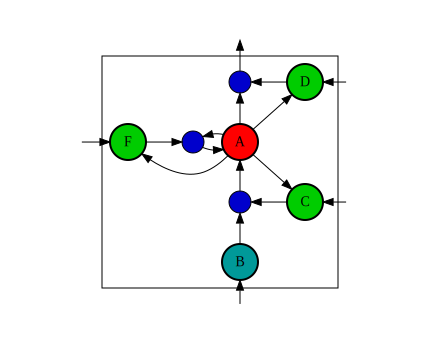

In [12]:
fig_7_7

TensorFlow には `tf.nn.rnn_cell.BasicLSTMCell` というクラスが用意されており利用可能。  
参照： [class tf.nn.rnn_cell.BasicLSTMCell](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/g3doc/api_docs/python/rnn_cell.md#class-tfnnrnn_cellbasiclstmcell-basiclstmcell)

In [ ]:
cell = tf.nn.rnn_cell.BasicLSTMCell(size, forget_bias=0.5)
(cell_output, new_state) = cell(inputs, old_state)

#### 7.5.3 順伝播計算

《略》

#### 7.5.4 逆伝播計算

《略》

### 7.6 入出力間で系列長が異なる場合

#### 7.6.1 隠れマルコフモデル

#### 7.6.2 コネクショニスト時系列分類法

《略》